### **Section 0: Setup**

Before start, follow readme file to set up directory structure

#### Install this package and restart runtime

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html


     |████████████████████████████████| 274 kB 4.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ccdd21db6671b8c3dea755e6fb3abf135a5b9939d6e79d420ba75de8567c5f3a
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 778 kB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 145 kB 10.6 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 130 kB 41.7 MB/s 
     |████████████████████████████████| 749 kB 37.5 MB/s 
     |███████████████████████████████

#### Get google drive

change GOOGLE_DRIVE_PATH_AFTER_MYDRIVE to your project dir in google drive

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive._mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB_535_self_driving_car/project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
# os.path.join(GOOGLE_DRIVE_PATH,"")
# ! cd GOOGLE_DRIVE_PATH
# !ls

['final_ensemble.ipynb', 'rob535-fall2021-final-project-data', 'classes.csv', 'full_dataset.pkl', '2D_bbox.csv', 'output', 'trainval_labels.csv', 'data', 'test_dir.csv', 'ROB535_Task1', 'Image_Cartype_Detectron2', 'Stacked_EfficientV2s_softVoting_Team11_flag.csv', 'final_ensemble_output.csv']


### **Section 1: Abhishek's Image Classification method**


#### Importing all necessary libraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import random
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import tensorflow
import shutil
import datetime
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

#### Mounting google drive and printing the first 5 rows of classes DataFrame
only run this one time becuase of the chdir

In [7]:
#Mounting google drive and checking the classes.csv file
# from google.colab import drive
# drive._mount('/content/drive')  

#Changing directory
# os.chdir('/content/drive/MyDrive/ROB_535_self_driving_car/project')
os.chdir(GOOGLE_DRIVE_PATH)
# os.chdir('../../../../')
print(os.getcwd())
df = pd.read_csv("classes.csv")
df.head()

/content/drive/.shortcut-targets-by-id/1_mCLTbzKZMPgpDidFlrEOqSG8OuqFihU/project


,class_id,class_name,label
0,0,Unknown,0
1,1,Compacts,1
2,2,Sedans,1
3,3,SUVs,1
4,4,Coupes,1


#### Reference functions to run the custom test generator

In [8]:
#Transforming labels to appropriate classes for csv submission
def convert_label(label):
  """
  Takes an input predicted label from model and converts it into 
  the final class label 0/1/2
  """
  if label == 3 or label == 4 or label == 5:
    return 2
  elif label == 6 or label == 7:
    return 0
  else:
    return label

def sub_model_label(label):
  """
  Takes an input predicted label for stacked sub classifier and 
  outputs class label as itself or 2
  """
  if label == 0:
    return 2
  else:
    return label

#Reference classes list -- Preprocessed train set into 8 sub directories
classes_ls = ["Unknown_and_Others", "Cars", "2_Wheeler", "Offroad", "Industrial", "Utility", "Service", "Commercial"]

#### Creating a soft voting ensemble model classifier using EfficientNetV2s

In [9]:
#Defining custom test generator with soft voting
def custom_augmentation_testgen(test_npy_file, 
                                saved_full_model_path,
                                saved_subset_model_path1,
                                saved_subset_model_path2,
                                test_files,
                                csv_file_name):
  
  """
  Inputs:
  test_npy_file: Input numpy file which contains test images in form (batch, size, size, channel_size)
  Use np.load("test_npy_file") to use it for custom generator

  saved_full_model_path: Full 8 classes classifier model path

  saved_subset_model_path1: Cars, Offroad and Utility class classfier model path
  Preferred when class label is Cars or Utility

  saved_subset_model_path2: Second Cars, Offroad and Utility class classfier model path 
  Preferred when class label is Offroad

  test_files: Test files loaded using glob from the directory -- Used to create column in DataFrame

  csv_file_name: Output csv file name to store the submission 

  Output: Submission csv file to upload on Kaggle
  """

  #Aggregating predictions on each test image
  prediction_ls = []
    
  #Used for prioritizing between stacked Image Classifier and Object Detection model -- 0/1
  flag_label = []

  #Loading saved full model
  checkpoint_path = saved_full_model_path
  test_model_1 = load_model(checkpoint_path, custom_objects={'KerasLayer':hub.KerasLayer})

  #Loading saved subset model 1 -- Trained on Cars, Offroad and Utility class only 
  #Preferred when class is Cars or Utility
  checkpoint_path2 = saved_subset_model_path1
  test_model_2 = load_model(checkpoint_path2, custom_objects={'KerasLayer':hub.KerasLayer})

  #Loading saved subset model 2 -- Trained on Cars, Offroad and Utility class only
  #Preferred when class is Offroad
  checkpoint_path3 = saved_subset_model_path2
  test_model_3 = load_model(checkpoint_path3, custom_objects={'KerasLayer':hub.KerasLayer})

  for img in tqdm_notebook(test_npy_file):
    #Stacking 6 rescaled images - the original, random shift 0.1*x & 0.1*y, random rotation 10 degrees,
    #                             random brightness, random zoom 0.1 and random shear - intensity 8
    batch_img = np.vstack((img[np.newaxis, :]/255,
                          
                          tf.keras.preprocessing.image.random_shift(
                          img, wrg = 0.1, hrg = 0.1, row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255, 
                          
                          tf.keras.preprocessing.image.random_rotation(
                          img, rg = 10, row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255,

                          tf.keras.preprocessing.image.random_brightness(
                          img, brightness_range = (0.3,0.7))[np.newaxis, :]/255,

                          tf.keras.preprocessing.image.random_zoom(
                          img, zoom_range = (0.1,0.1), row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255, 

                          tf.keras.preprocessing.image.random_shear(
                          img, intensity = 8, row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255                                   
                          ))
    
    #Checking whether the batch_img is valid or not
    assert batch_img.shape[0] == 6

    #Obtain predictions from the batch Image data
    predictions = test_model_1.predict(batch_img)
    assert predictions.shape[0] == batch_img.shape[0]

    #Performing soft voting based on probabilities -- single classifier
    final_label = np.argmax(np.average(predictions, axis=0))
    img_class = classes_ls[final_label]

    #Building stacking classifier if predicted is either Cars, Offroad or Utility class 
    if img_class == "Cars" or img_class == "Utility":
      
      #Predicting using seperate subset classifier 1 trained on these 3 classes 
      pred = test_model_2.predict(batch_img)
      assert pred.shape[0] == batch_img.shape[0]

      #Implementing soft voting and appending the predicted label
      label = np.argmax(np.average(pred, axis=0))
      prediction_ls.append(sub_model_label(label))
      flag_label.append(1)

    elif img_class == "Offroad":

      #Predicting using seperate subset classifier 1 trained on these 3 classes 
      pred = test_model_3.predict(batch_img)
      assert pred.shape[0] == batch_img.shape[0]

      #Implementing soft voting and appending the predicted label
      label = np.argmax(np.average(pred, axis=0))
      prediction_ls.append(sub_model_label(label))
      flag_label.append(1)

    else:
      prediction_ls.append(convert_label(final_label))
      flag_label.append(0)

  #Creating a dataframe and saving it as output
  assert len(prediction_ls) == test_npy_file.shape[0]

  #Based on submission regulations
  image_file = [fname[5:-10] for fname in test_files]
  data = {'guid/image': image_file, 'label': prediction_ls, 'flag':flag_label}
  
  #Creating the pandas DataFrame and saving it
  output_df = pd.DataFrame(data)
  output_df.to_csv(csv_file_name, index=False)
  print("File_downloaded as .csv!!")

#### Obtaining prediction results with Step 1 csv file

In [10]:
#Running the function
test_npy_file = np.load("ROB535_Task1/effv2s_test_x.npy") #Contains each image of dim (384,384,3) -- Input for EfficientV2s model
model_path = "ROB535_Task1/Models/training-017-0.9035-0.7473.h5"
model_path2 = "ROB535_Task1/Models/training-001-0.7265-0.7889.h5"
model_path3 = "ROB535_Task1/Models/training-016-0.7580-0.7930.h5"
test_files = sorted(glob('data/test/*/*_image.jpg'))
file_name = "Stacked_EfficientV2s_softVoting_Team11_flag.csv"

custom_augmentation_testgen(test_npy_file = test_npy_file,
                            saved_full_model_path = model_path,
                            saved_subset_model_path1 = model_path2,
                            saved_subset_model_path2 = model_path3,
                            test_files = test_files,
                            csv_file_name = file_name)

  0%|          | 0/2631 [00:00<?, ?it/s]

File_downloaded as .csv!!


If this step take too long (it should take 25 min on colab), we have already stored the output in Stacked_EfficientV2s_softVoting_Team11_flag.csv

### **Section 2: Leyang's Object Detection Method**

Make sure already you installed detection2 and set up google drive in section 0

#### chdir
run this only once

In [11]:
os.chdir('../../../../')
print(os.getcwd())

/content


#### Import lib

In [12]:

from google.colab.patches import cv2_imshow

import torch, torchvision
import glob
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import csv
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

#### Format data

In [13]:
def rd_csv(file= 'trainval_labels',folder = 'rob535-fall2021-final-project-data'):
  labels = []
  lll = ()
  full_dataset = []
  folder = 'data'

  path_to_ann = os.path.join(GOOGLE_DRIVE_PATH,file+'.csv')

  if file == 'trainval_labels':
    with open(path_to_ann, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
      i = 0
      for row in spamreader:
        i+=1
        data_dict = {}
        
          
        if i == 1:
          continue
        else:
          dir = row[0].split('/')
          here = dir[-1].replace('\\','/') 

          data_dict['img_path'] = os.path.join(GOOGLE_DRIVE_PATH,folder,here+'_image.jpg')
          data_dict['guid'] = here
          label = int(row[1])
          
          if label<16:
            label = label-1
          elif label <20:
            label = label -2
          else:
            label = label -3
          labels.append(label)
          data_dict['label'] = label
          bbox = np.array((row[2:]))
          bbox2 = bbox.astype(np.float)

          data_dict['bbox'] = bbox2
          full_dataset.append(data_dict)
        # if i == 6500:
        #   break

    n = len(full_dataset)
    
    labels = list( dict.fromkeys(labels) )
    # print(len(labels))
    # print(full_dataset[0])
    return full_dataset
  else:
    with open(path_to_ann, newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
      i = 0
      for row in spamreader:
        i+=1
        data_dict = {}
        guid = row[0].split('\\')
        image = guid[-1].split('_')[0]
        guid = guid[-2]
        # guid/image,label
        # 0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0009,2
        
        data_dict['img_path'] = os.path.join(GOOGLE_DRIVE_PATH,folder,'test',guid,image+'_image.jpg')
        data_dict['guid'] = guid+'/'+image
        full_dataset.append(data_dict)

    return full_dataset
full_dataset = rd_csv()
test_dataset = rd_csv('test_dir')

# print(full_dataset[0]['bbox']+1)


In [14]:
from detectron2.structures import BoxMode

def get_car_dicts(d, n):
  # with open(os.path.join(GOOGLE_DRIVE_PATH,'full_dataset.pkl'), 'rb') as f:
  #   full_dataset = pickle.load(f)
  full_dataset = rd_csv()
  if d =="train":
    imgs_anns = full_dataset[:n]
  elif d == "val":
    imgs_anns = full_dataset[n:]
   
  else:
    print('wrong d')

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns):
      record = {}
      
      filename = v["img_path"]
      # height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = 1052 #height
      record["width"] = 1914 #width
    
      # annos = v["regions"]
      objs = []
      # for _, anno in annos.items():
        # assert not anno["region_attributes"]
        # anno = anno["shape_attributes"]
        # px = anno["all_points_x"]
        # py = anno["all_points_y"]
        # poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        # poly = [p for x in poly for p in x]

      obj = {
          "bbox": v['bbox'],
          # "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
          "bbox_mode": BoxMode.XYXY_ABS,
          # "segmentation": [poly],
          "category_id": v['label'],
      }
      objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts
n = -1


for d in ["train", "val"]:
    DatasetCatalog.register("car_" + d, lambda d=d: get_car_dicts(d,n))
    MetadataCatalog.get("car_" + d).set(thing_classes=['Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Planes', 'Service', 'Emergency',
    'Commercial', 'Trains'])

#['Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    # 'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    # 'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    # 'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    # 'Military', 'Commercial', 'Trains'])
car_metadata = MetadataCatalog.get("car_train")

#### If you need to re-run the last block, you need to remove exisitng catalog first

In [15]:
# DatasetCatalog.remove("car_train")
# MetadataCatalog.remove("car_train")
# DatasetCatalog.remove("car_val")
# MetadataCatalog.remove("car_val")
DatasetCatalog

DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_se

#### Set up config file

In [16]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [30]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-3  
cfg.SOLVER.MAX_ITER = 80000    
cfg.SOLVER.STEPS = (55000,65000,75000)
cfg.SOLVER.GAMMA = 0.2        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128    
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.CHECKPOINT_PERIOD = 5000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20 

cfg.OUTPUT_DIR = os.path.join(GOOGLE_DRIVE_PATH,"output")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_0054999.pth')# "model_final.pth")
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 0
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('car_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5'

#### Inference

In [35]:
predictor = DefaultPredictor(cfg)

#### No need to run but this looks cool

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'bbox': array([1900.52490757,  398.34498742, 1914.        ,  481.80622575]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}]
tensor([1, 0, 4, 1], device='cuda:0')


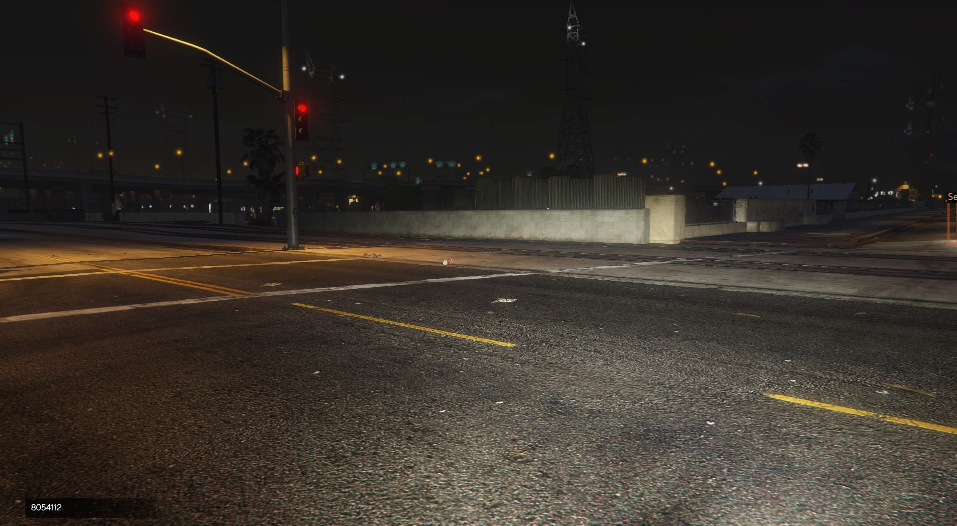

[{'bbox': array([ 55.5608266 , 376.55559368, 431.66288355, 492.94065705]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4}]
tensor([4, 6, 1, 5], device='cuda:0')


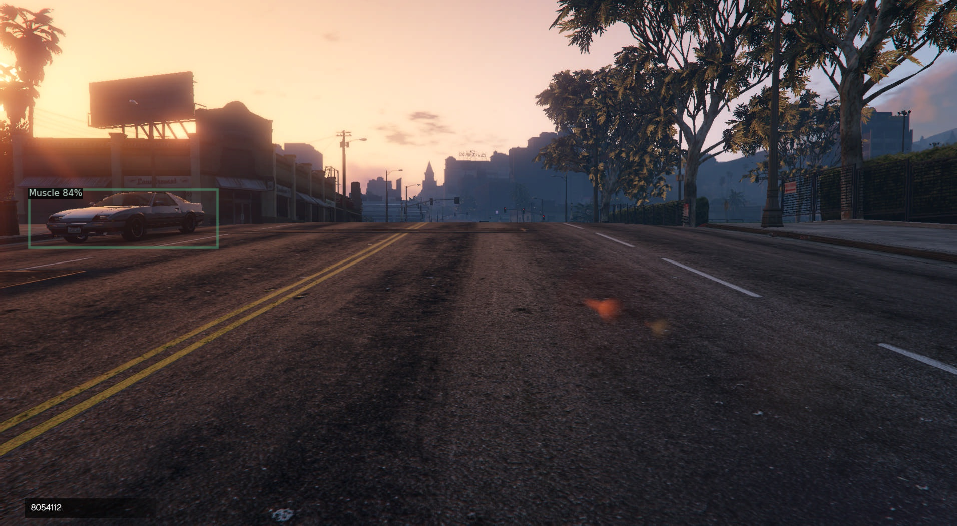

[{'bbox': array([547.47964741, 448.43629053, 811.92983648, 540.95389533]), 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}]
tensor([1], device='cuda:0')


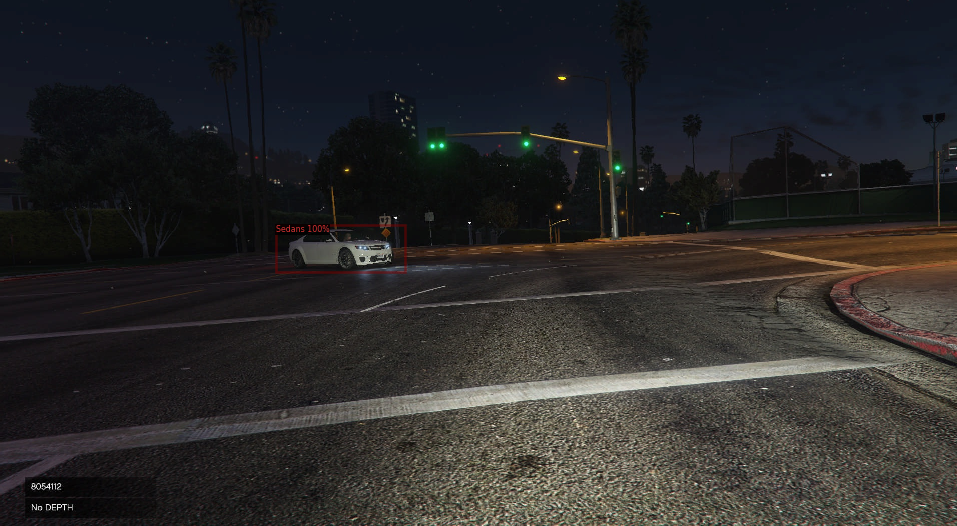

In [20]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_car_dicts('train',n)
# dataset_dicts = get_car_dicts('val',n)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(d["annotations"])
    print(outputs["instances"].pred_classes)
    v = Visualizer(im[:, :, ::-1],
                   metadata=car_metadata, 
                   scale=0.5, 
                   
    )
    out = v.draw_instance_predictions(outputs["instances"][:1].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

#### Store output for section 2

set test = True

and this block will output the label for test set in output/output.csv


set test = False

and this block will output the label for eval set in output/eval_output.csv

In [32]:
output = [] 
test = True
if test:
  test_dataset = rd_csv('test_dir')
  nnn=len(test_dataset)
  for id, d in enumerate(test_dataset):    
      im = cv2.imread(d["img_path"])
      # print(d["img_path"])
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      # print(d["annotations"])
      pred_list = outputs["instances"].pred_classes
      if len(pred_list) == 0:
        output.append([d['guid'],0,pred_list]) # 0 or 2
        continue
      pred = pred_list[0]
      print(id,'/',nnn, pred_list)
      if pred>13 or len(pred_list) == 0:
        output.append([d['guid'],0,pred_list])
      elif pred<8:
        output.append([d['guid'],1,pred_list])
      elif pred<14:
        output.append([d['guid'],2,pred_list])

      # if id>3:
      #   break
  print('writing')
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","output"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                              quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','label'])
      for out in output:
        spamwriter.writerow(out[:2])

  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","log"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','label','pred'])
      for out in output:
        spamwriter.writerow(out)
else:
  eval_dataset = rd_csv()
  d='val'
  if d =="train":
    eval_dataset = eval_dataset[:n]
  elif d == "val":
    eval_dataset = eval_dataset[n:]
  nnn=len(eval_dataset)
  for id, d in enumerate(eval_dataset):    
      im = cv2.imread(d["img_path"])
      # print(d["img_path"])
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      # print(d["annotations"])
      pred_list = outputs["instances"].pred_classes
      
      pred = d['label']
      if pred>13 or len(pred_list) == 0:
        gt_label = 0
      elif pred<8:
        gt_label = 1
      elif pred<14:
        gt_label = 2

      if len(pred_list) == 0:
        output.append([d['guid'],d['label'],0,pred_list]) # 0 or 2
        continue
      pred = pred_list[0]
      print(id,'/',nnn,d['label'], pred_list)
      if pred>13 or len(pred_list) == 0:
        output.append([d['guid'],gt_label,0,d['label'],pred_list])
      elif pred<8:
        output.append([d['guid'],gt_label,1,d['label'],pred_list])
      elif pred<14:
        output.append([d['guid'],gt_label,2,d['label'],pred_list])

      # if id>3:
      #   break
  print('writing')
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","eval_log"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','gt_label','label','gt_pred','pred'])
      for out in output:
        spamwriter.writerow(out)
print('finished')

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


0 / 2631 tensor([16], device='cuda:0')
1 / 2631 tensor([16,  8], device='cuda:0')
2 / 2631 tensor([16], device='cuda:0')
3 / 2631 tensor([16], device='cuda:0')
4 / 2631 tensor([16], device='cuda:0')
5 / 2631 tensor([16], device='cuda:0')
6 / 2631 tensor([16], device='cuda:0')
7 / 2631 tensor([16], device='cuda:0')
8 / 2631 tensor([16,  8], device='cuda:0')
9 / 2631 tensor([12,  1, 10,  2,  1,  1], device='cuda:0')
10 / 2631 tensor([1], device='cuda:0')
11 / 2631 tensor([1], device='cuda:0')
12 / 2631 tensor([1], device='cuda:0')
13 / 2631 tensor([1], device='cuda:0')
14 / 2631 tensor([1, 3, 2, 6, 4], device='cuda:0')
15 / 2631 tensor([11], device='cuda:0')
17 / 2631 tensor([11, 18, 18, 11], device='cuda:0')
18 / 2631 tensor([18, 11], device='cuda:0')
19 / 2631 tensor([18, 11], device='cuda:0')
20 / 2631 tensor([18, 11, 18], device='cuda:0')
21 / 2631 tensor([18, 11, 11], device='cuda:0')
22 / 2631 tensor([18, 11, 12, 11], device='cuda:0')
23 / 2631 tensor([18, 11,  9], device='cuda:0')

If this step take too long (it should take 15 min), we have already stored the output in output/output.csv

#### Temporal Convolution to improve result

In [33]:

import copy
for name in ['output','output_temp']:
  output = []
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output",name+'.csv'),'r', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idx,row in enumerate(spamreader):
      if idx ==0:
        continue
      output.append(row)
      # print(row)
  output_temp = copy.deepcopy(output)

  for id, out in enumerate(output):
    out = out[1]
    if id < 2 or id > len(output)-3:
      continue
    try:
      after = output[id+1][1]
      before = output[id-1][1]
      # print(id,out,before,after)
      if out ==after or out==before:
        output_temp[id][1] = out
        # print('...',end=',')
      else:
        if before == after:
          output_temp[id][1] = before
        elif output[id-2][1] == before and output[id-3][1] == before and output[id-4][1] == before:
          output_temp[id][1] = before
        elif output[id+2][1] == after and output[id+3][1] == after and output[id+4][1] == after:
          output_temp[id][1] = after
        elif output[id-2][1] == before and output[id-3][1] == before:
          output_temp[id][1] = before
        elif output[id+2][1] == after and output[id+3][1] == after:
          output_temp[id][1] = after
    except:
      pass

    # print(output[id],end=',')
    # print(output_temp[id][1])
  with open(os.path.join(GOOGLE_DRIVE_PATH,"output","output_temp"+'.csv'), 'w', newline='') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                              quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerow(['guid/image','label'])
      for out in output_temp:
        spamwriter.writerow(out[:2])

### **Section 3: Ensemble of Methods**

In [34]:
import csv
import copy
output2 = []
name = 'output_temp'
with open(os.path.join(GOOGLE_DRIVE_PATH,"output",name+'.csv'),'r', newline='') as csvfile:
  spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
  for idx,row in enumerate(spamreader):
    if idx ==0:
      continue
    output2.append(row)

output1 = []
name = "Stacked_EfficientV2s_softVoting_Team11_flag"
with open(os.path.join(GOOGLE_DRIVE_PATH,name+'.csv'),'r', newline='') as csvfile:
  spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
  for idx,row in enumerate(spamreader):
    if idx ==0:
      continue
    output1.append(row)
print(output1)

final_output = copy.deepcopy(output2)
for id, out1 in enumerate(output1):
  # print(out1[2]==0)
  if out1[2]=='0':
    # print(out1[:2])
    final_output[id] = out1[:2]

with open(os.path.join(GOOGLE_DRIVE_PATH,"final_ensemble_output"+'.csv'), 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['guid/image','label'])
    for out in final_output:
      spamwriter.writerow(out[:2])

[['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0000', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0001', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0002', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0003', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0004', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0005', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0006', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0007', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0008', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0009', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0010', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0011', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0012', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0013', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0014', '0', '0'], ['test/0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0015', '2', '1'], ['test/

The end, final output will be stored in final_ensemble_output.csv